In [1]:
import torch

gpu_index = 6
torch.cuda.set_device(gpu_index)

print(torch.cuda.current_device())

/opt/conda/envs/environment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


6


In [2]:
import os
import time
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from monai import transforms
from monai.config import print_config
from monai.utils import first, set_determinism
from monai.data import CacheDataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

from generative.inferers import DiffusionInferer, LatentDiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/envs/environment/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.10.1
Pillow version: 10.1.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSIO

In [5]:
import os
import pandas as pd
import cv2

# Load the CSV file
train_data = pd.read_csv("/root/group2/data_256/Training/train.csv")

# Filter the DataFrame for glioma images only
glioma_data = train_data[train_data['Label'] == 'pituitary']

# Count the number of images per plane for glioma and find the minimum count
plane_counts_glioma = glioma_data['Plane'].value_counts()
min_plane_count_glioma = plane_counts_glioma.min()

# Set the paths
input_folder = '/root/group2/data_256/Training/pituitary'
output_folder = '/root/group2/data_128_pituitary'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Initialize counters for each plane
processed_counts = {'axial': 0, 'coronal': 0, 'sagittal': 0}

# Process images, keeping track of the count per plane
for index, row in glioma_data.iterrows():
    plane = row['Plane']
    filename = row['Path'].split('/')[-1]

    # Check if we haven't exceeded the count for the plane
    if processed_counts[plane] < min_plane_count_glioma:
        img_path = os.path.join(input_folder, filename)
        if os.path.exists(img_path):
            # Read the image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Resize the image to 128x128
            resized_img = cv2.resize(img, (128, 128))

            # Save the resized image to the output folder
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, resized_img)

            # Update the count for the plane
            processed_counts[plane] += 1

print("Image resizing and saving complete.")
print("Processed counts per plane:", processed_counts)

Image resizing and saving complete.
Processed counts per plane: {'axial': 223, 'coronal': 223, 'sagittal': 223}


In [6]:
import random

set_determinism(33)
random.seed(33)

In [7]:
def load_images_and_labels(data_dir, label):
    image_files = glob.glob(os.path.join(data_dir, '*.jpg'))
    return [{"image": img, "label": label} for img in image_files]

In [8]:
import os
import pandas as pd
import random

# Load the CSV file and create a mapping from filenames to plane types
train_data_csv = pd.read_csv("/root/group2/data_256/Training/train.csv")
filename_to_plane = {row['Path'].split('/')[-1]: row['Plane'] for _, row in train_data_csv.iterrows()}

# Directories for glioma tumor class
directories = [("/root/group2/data_128_pituitary", "pituitary")]

# Load and concatenate data from the directory
all_data = []
for data_dir, label in directories:
    all_data.extend(load_images_and_labels(data_dir, label))

# Split ratio for training and validation sets
split_ratio = 0.8

# Group images by plane type
grouped_data = {'axial': [], 'coronal': [], 'sagittal': []}
for item in all_data:
    # Extract filename and lookup its plane type
    filename = item['image'].split('/')[-1]
    plane_type = filename_to_plane.get(filename, 'unknown')
    if plane_type in grouped_data:
        grouped_data[plane_type].append(item)

# Split each group into training and validation sets
train_data = []
val_data = []

for plane, items in grouped_data.items():
    random.shuffle(items)  # Shuffle the data for randomness
    split_index = int(len(items) * split_ratio)
    train_data.extend(items[:split_index])
    val_data.extend(items[split_index:])

# Shuffle the combined training and validation sets to mix plane types
random.shuffle(train_data)
random.shuffle(val_data)

transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)

# Now you can continue with your existing code for creating datasets and dataloaders...
train_ds = CacheDataset(data=train_data, transform=transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, persistent_workers=True)

val_ds = CacheDataset(data=val_data, transform=transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4, persistent_workers=True)

Loading dataset: 100%|██████████| 135/135 [00:00<00:00, 605.70it/s]


In [9]:
# Extracting the last part of the image path to use as Image ID
image_ids = [data['image'].split('/')[-1].replace('.jpg', '') for data in train_data]

# Filter the DataFrame to include only rows with Image IDs in the validation set
val_df = train_data_csv[train_data_csv['Image ID'].isin(image_ids)]

# Count the number of images from each plane in the validation set
val_plane_counts = val_df['Plane'].value_counts()

val_plane_counts

Plane
coronal     178
axial       178
sagittal    178
Name: count, dtype: int64

batch shape: torch.Size([16, 1, 128, 128])


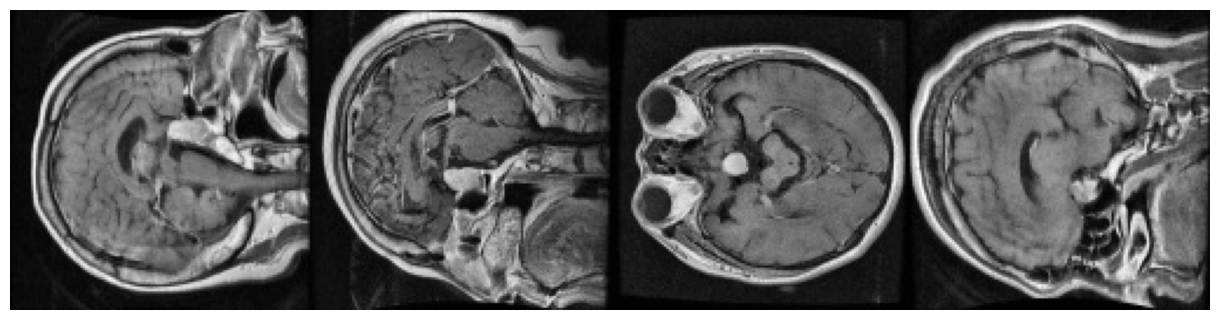

In [10]:
check_data = next(iter(train_loader))
print(f"batch shape: {check_data['image'].shape}")
images = check_data['image']

# Concatenate the first four images in the batch along width
image_visualisation = torch.cat(
    [images[0, 0], images[1, 0], images[2, 0], images[3, 0]], dim=1
)


# Visualize the concatenated images
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, cmap="gray")
plt.axis("off")
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)

plt.show()

In [11]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=128,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)
inferer = DiffusionInferer(scheduler)

Epoch 0:   0%|                                 | 0/34 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:15<00:00, 63.79it/s]


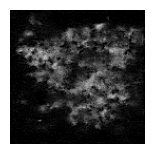

100%|██████████| 1000/1000 [00:16<00:00, 62.25it/s]


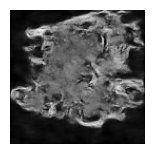

100%|██████████| 1000/1000 [00:15<00:00, 63.65it/s]


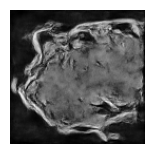

100%|██████████| 1000/1000 [00:15<00:00, 62.89it/s]


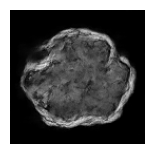

100%|██████████| 1000/1000 [00:15<00:00, 63.82it/s]


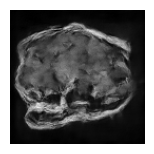

100%|██████████| 1000/1000 [00:15<00:00, 63.36it/s]


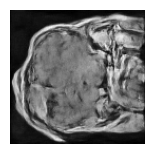

100%|██████████| 1000/1000 [00:15<00:00, 63.70it/s]


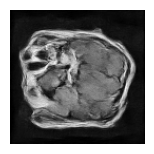

100%|██████████| 1000/1000 [00:15<00:00, 63.58it/s]


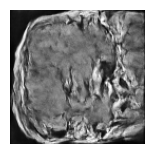

100%|██████████| 1000/1000 [00:15<00:00, 63.23it/s]


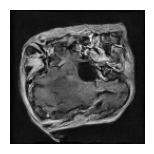

100%|██████████| 1000/1000 [00:15<00:00, 63.93it/s]


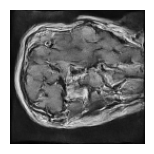

100%|██████████| 1000/1000 [00:15<00:00, 63.31it/s]


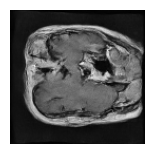

100%|██████████| 1000/1000 [00:16<00:00, 61.94it/s]


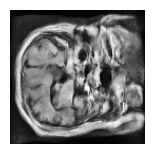

100%|██████████| 1000/1000 [00:15<00:00, 64.16it/s]


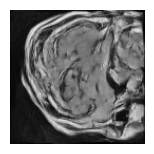

100%|██████████| 1000/1000 [00:15<00:00, 64.17it/s]


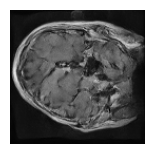

100%|██████████| 1000/1000 [00:15<00:00, 64.61it/s]


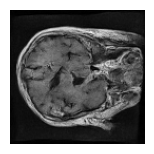

100%|██████████| 1000/1000 [00:15<00:00, 63.32it/s]


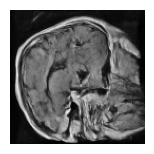

100%|██████████| 1000/1000 [00:15<00:00, 63.33it/s]


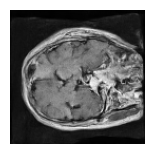

100%|██████████| 1000/1000 [00:15<00:00, 64.82it/s]


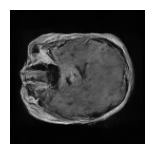

100%|██████████| 1000/1000 [00:15<00:00, 63.96it/s]


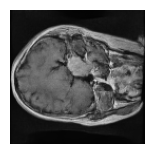

100%|██████████| 1000/1000 [00:15<00:00, 63.61it/s]


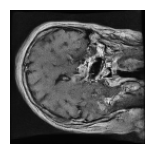

100%|██████████| 1000/1000 [00:15<00:00, 62.82it/s]


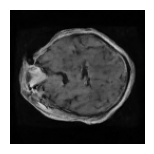

100%|██████████| 1000/1000 [00:15<00:00, 63.82it/s]


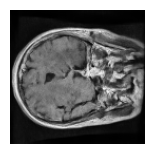

100%|██████████| 1000/1000 [00:15<00:00, 63.68it/s]


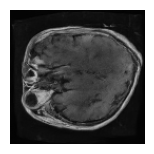

100%|██████████| 1000/1000 [00:16<00:00, 61.98it/s]


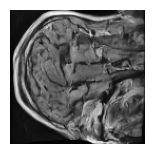

100%|██████████| 1000/1000 [00:15<00:00, 64.60it/s]


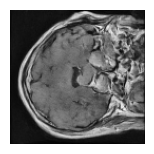

100%|██████████| 1000/1000 [00:15<00:00, 63.75it/s]


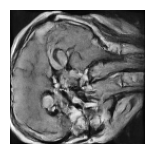

100%|██████████| 1000/1000 [00:15<00:00, 63.88it/s]


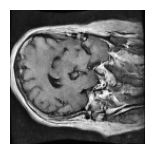

100%|██████████| 1000/1000 [00:15<00:00, 63.89it/s]


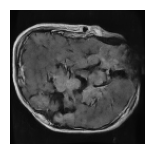

100%|██████████| 1000/1000 [00:15<00:00, 63.70it/s]


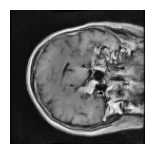

100%|██████████| 1000/1000 [00:15<00:00, 63.65it/s]


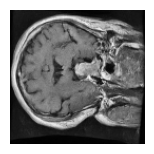

100%|██████████| 1000/1000 [00:15<00:00, 65.46it/s]


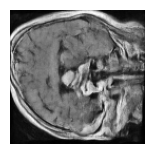

100%|██████████| 1000/1000 [00:15<00:00, 63.82it/s]


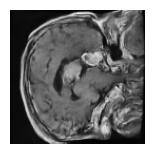

100%|██████████| 1000/1000 [00:15<00:00, 63.60it/s]


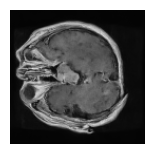

100%|██████████| 1000/1000 [00:15<00:00, 64.24it/s]


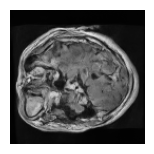

100%|██████████| 1000/1000 [00:15<00:00, 63.17it/s]


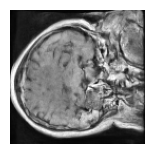

100%|██████████| 1000/1000 [00:15<00:00, 63.34it/s]


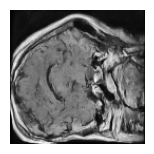

100%|██████████| 1000/1000 [00:15<00:00, 64.04it/s]


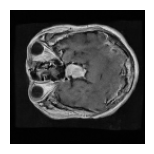

100%|██████████| 1000/1000 [00:15<00:00, 63.72it/s]


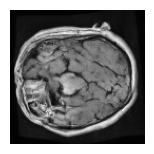

100%|██████████| 1000/1000 [00:15<00:00, 63.10it/s]


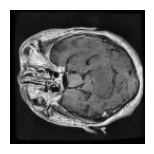

100%|██████████| 1000/1000 [00:16<00:00, 61.87it/s]


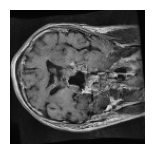

100%|██████████| 1000/1000 [00:16<00:00, 61.89it/s]


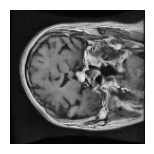

100%|██████████| 1000/1000 [00:16<00:00, 61.50it/s]


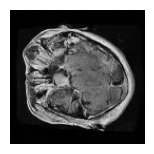

100%|██████████| 1000/1000 [00:16<00:00, 62.00it/s]


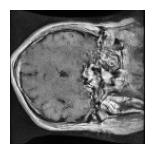

100%|██████████| 1000/1000 [00:16<00:00, 61.60it/s]


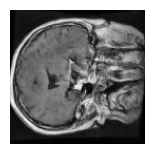

100%|██████████| 1000/1000 [00:16<00:00, 61.75it/s]


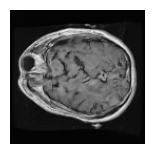

100%|██████████| 1000/1000 [00:16<00:00, 61.84it/s]


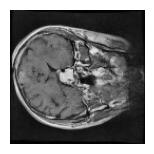

100%|██████████| 1000/1000 [00:15<00:00, 62.82it/s]


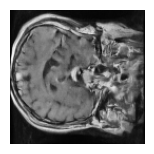

100%|██████████| 1000/1000 [00:16<00:00, 61.78it/s]


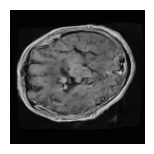

100%|██████████| 1000/1000 [00:16<00:00, 61.91it/s]


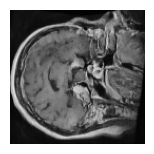

100%|██████████| 1000/1000 [00:16<00:00, 61.98it/s]


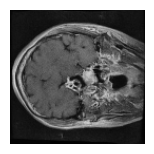

100%|██████████| 1000/1000 [00:16<00:00, 62.02it/s]


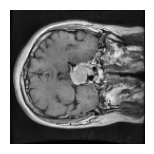

100%|██████████| 1000/1000 [00:16<00:00, 61.54it/s]


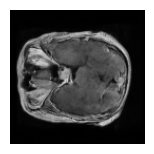

100%|██████████| 1000/1000 [00:16<00:00, 61.77it/s]


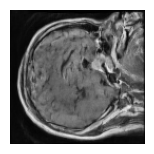

100%|██████████| 1000/1000 [00:16<00:00, 61.67it/s]


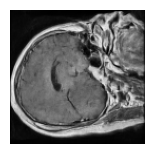

100%|██████████| 1000/1000 [00:16<00:00, 59.91it/s]


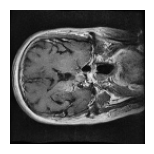

100%|██████████| 1000/1000 [00:16<00:00, 61.47it/s]


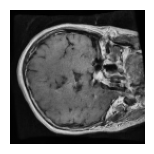

100%|██████████| 1000/1000 [00:16<00:00, 60.74it/s]


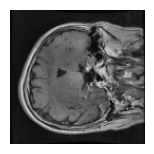

100%|██████████| 1000/1000 [00:16<00:00, 62.23it/s]


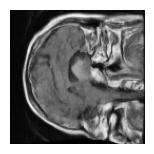

100%|██████████| 1000/1000 [00:17<00:00, 57.53it/s]


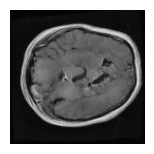

100%|██████████| 1000/1000 [00:16<00:00, 61.70it/s]


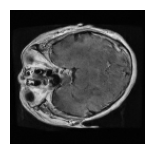

100%|██████████| 1000/1000 [00:16<00:00, 62.05it/s]


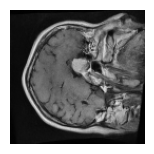

100%|██████████| 1000/1000 [00:16<00:00, 62.19it/s]


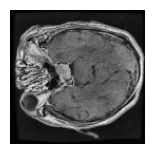

100%|██████████| 1000/1000 [00:16<00:00, 61.48it/s]


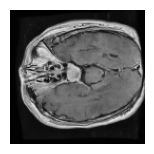

100%|██████████| 1000/1000 [00:16<00:00, 62.03it/s]


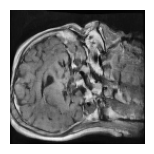

100%|██████████| 1000/1000 [00:16<00:00, 60.10it/s]


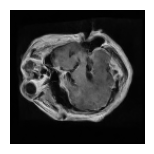

100%|██████████| 1000/1000 [00:16<00:00, 61.42it/s]


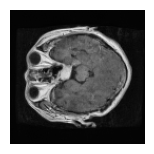

100%|██████████| 1000/1000 [00:16<00:00, 61.97it/s]


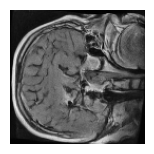

100%|██████████| 1000/1000 [00:16<00:00, 62.29it/s]


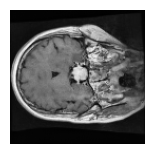

100%|██████████| 1000/1000 [00:16<00:00, 62.03it/s]


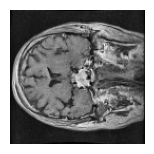

100%|██████████| 1000/1000 [00:16<00:00, 62.22it/s]


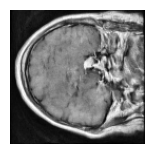

100%|██████████| 1000/1000 [00:16<00:00, 62.00it/s]


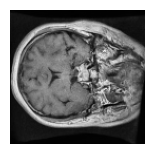

100%|██████████| 1000/1000 [00:16<00:00, 61.90it/s]


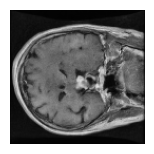

100%|██████████| 1000/1000 [00:16<00:00, 62.06it/s]


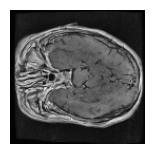

100%|██████████| 1000/1000 [00:16<00:00, 61.41it/s]


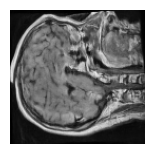

100%|██████████| 1000/1000 [00:16<00:00, 61.64it/s]


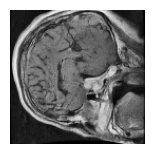

Train completed, total time: 10464.865551710129.


In [12]:
n_epochs = 750
val_interval = 10
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device).float()
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            noise = torch.randn_like(images).to(device)  # Generate random noise
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device).long()  # Create timesteps
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)   # Get model prediction
            loss = F.mse_loss(noise_pred.float(), noise.float())   # Count loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device).float()
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images)
                    timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        noise = torch.randn((1, 1, 128, 128), device=device).float() 
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"Train completed, total time: {total_time}.")

100%|██████████| 1000/1000 [00:15<00:00, 62.59it/s]


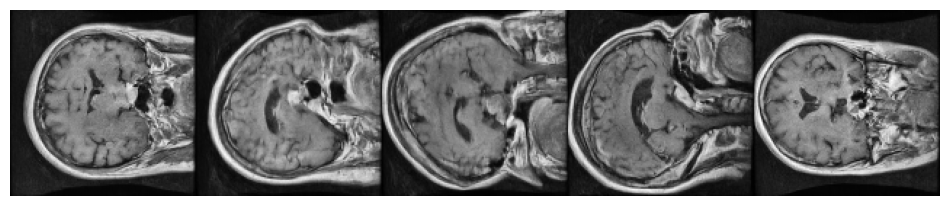

In [13]:
num_images = 5
generated_images = []

for _ in range(num_images):
    noise = torch.randn((1, 1, 128, 128)).to(device)
    
    scheduler.set_timesteps(num_inference_steps=1000)
    with torch.cuda.amp.autocast():
        generated_image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
    
    generated_images.append(generated_image)

# Concatenate the generated images horizontally
generated_images = torch.cat(generated_images, dim=3)


# Display the concatenated images
plt.figure(figsize=(12, 4))
plt.imshow(generated_images[0, 0].cpu().detach(), vmin=0, vmax=1, cmap='gray')
plt.axis('off')
plt.show()

In [16]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import rotate, zoom

# Define the number of images to generate
num_images = 288

output_dir = "/root/group2/generated_images/pituitary_256"
os.makedirs(output_dir, exist_ok=True)

for i in range(num_images):
    noise = torch.randn((1, 1, 128, 128)).to(device)
    
    scheduler.set_timesteps(num_inference_steps=1000)
    with torch.cuda.amp.autocast():
        generated_image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

    image_to_save = generated_image[0, 0].cpu().detach().numpy()
    rotated_image = rotate(image_to_save, -90, reshape=False)
    resized_image = zoom(rotated_image, (256 / 128, 256 / 128))

    save_path = os.path.join(output_dir, f"pituitary_{i+1+312}.jpg")
    
    # Save the resized image
    plt.imsave(save_path, resized_image, vmin=0, vmax=1, cmap='gray')

print("All images generated, rotated, resized, and saved.")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:15<00:00, 62.65it/s]

All images generated, rotated, resized, and saved.
